# SpamHam Text Classification

<b> Imports</b>

In [24]:
import os
from collections import Counter
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


## Making the data sets

In [96]:
# I've copied all spam and ham emails in singel directory 'emails', now making the data.
def make_data():
    direc = 'emails/'
    files = os.listdir(direc)
    emails = np.array([direc+email for email in files])
    
    random.shuffle(emails)
    
    email_col = np.array([[]])
    label = np.array([[]])
    c = len(emails)
    for email in emails:
        f = open(email, encoding='utf8', errors='ignore')
        blob = f.read()
        email_col = np.append(email_col, blob)
        if 'phishing' in email:
            label = np.append(label, 'phishing')
        elif 'malicious' in email:
            label = np.append(label, 'malicious')
        elif 'harmful' in email:
            label = np.append(label, 'harmful')
        elif 'solicited' in email:
            label = np.append(label, 'solicited')
        elif 'spam' in email:
            label = np.append(label, 'spam')
        elif 'ham' in email:
            label = np.append(label, 'ham')

        c-=1
        print(c)
        
    return email_col, label
        

In [97]:
emails, labels = make_data()

10245
10244
10243
10242
10241
10240
10239
10238
10237
10236
10235
10234
10233
10232
10231
10230
10229
10228
10227
10226
10225
10224
10223
10222
10221
10220
10219
10218
10217
10216
10215
10214
10213
10212
10211
10210
10209
10208
10207
10206
10205
10204
10203
10202
10201
10200
10199
10198
10197
10196
10195
10194
10193
10192
10191
10190
10189
10188
10187
10186
10185
10184
10183
10182
10181
10180
10179
10178
10177
10176
10175
10174
10173
10172
10171
10170
10169
10168
10167
10166
10165
10164
10163
10162
10161
10160
10159
10158
10157
10156
10155
10154
10153
10152
10151
10150
10149
10148
10147
10146
10145
10144
10143
10142
10141
10140
10139
10138
10137
10136
10135
10134
10133
10132
10131
10130
10129
10128
10127
10126
10125
10124
10123
10122
10121
10120
10119
10118
10117
10116
10115
10114
10113
10112
10111
10110
10109
10108
10107
10106
10105
10104
10103
10102
10101
10100
10099
10098
10097
10096
10095
10094
10093
10092
10091
10090
10089
10088
10087
10086
10085
10084
10083
10082
10081
10080
1007

In [98]:
emails.shape, labels.shape

((10246,), (10246,))

In [99]:
# making them dimension ready
emails = emails[:, np.newaxis]
labels = labels[:, np.newaxis]

In [102]:
emails.shape, labels.shape

((10246, 1), (10246, 1))

In [155]:
len(emails.flatten())

10246

In [156]:
df = pd.DataFrame({'message': emails.flatten(), 'labels':labels.flatten()}, index=np.arange(len(emails.flatten())))

In [105]:
df.head()

,message,labels
0,Subject: Technical file notice: .scr (Sample M...,malicious
1,Subject: Security alert: microsoft account sec...,phishing
2,Subject: Promo alert – lowest price ever (Samp...,spam
3,Subject: Your reference number (Sample SOL-004...,solicited
4,Subject: Training sample with threat phrase: t...,harmful


preprocess email data

In [106]:
# from bs4 import BeautifulSoup
# from nltk import word_tokenize, WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
# def purify_text(message):
#     soup = BeautifulSoup(message)
#     text =  soup.get_text()
#     text = text.replace("\n", " ").replace("/", "").replace("|", "").replace("http", "").replace(':', "").replace('\t', "").replace("Subject", "").replace('re', "").strip()
#     tokens = word_tokenize(text)
#     temp = [lemmatizer.lemmatize(word.lower()) for word in tokens]
#     return ' '.join(temp)

# df['message'] = df['message'].apply(purify_text)

from bs4 import BeautifulSoup
from nltk import word_tokenize, WordNetLemmatizer
import re

lemmatizer = WordNetLemmatizer()

# pre-compiled regex patterns for speed on ~20k emails
URL_PATTERN = re.compile(r'https?://\S+|www\.\S+')
EMAIL_PATTERN = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w+\b')
HEADER_PATTERN = re.compile(r'\b(subject|re|fw|fwd)\b[:\-]*', flags=re.IGNORECASE)
MARKDOWN_LINK = re.compile(r'\[.*?\]\(.*?\)')
NON_ALNUM = re.compile(r'[^a-zA-Z0-9\s]')
MULTI_SPACE = re.compile(r'\s+')


def purify_text(message):
    # handle NaN / None / non-string
    if not isinstance(message, str):
        return ""

    # 1) strip HTML
    soup = BeautifulSoup(message, "html.parser")
    text = soup.get_text(separator=" ")

    # 2) remove markdown links like [text](url)
    text = MARKDOWN_LINK.sub(" ", text)

    # 3) remove URLs and email addresses
    text = URL_PATTERN.sub(" ", text)
    text = EMAIL_PATTERN.sub(" ", text)

    # 4) remove common header noise (Subject:, Re:, Fwd:, etc.)
    text = HEADER_PATTERN.sub(" ", text)

    # 5) normalize whitespace and basic control chars
    text = text.replace("\n", " ").replace("\t", " ")

    # 6) remove most punctuation/symbols
    text = NON_ALNUM.sub(" ", text)

    # 7) collapse multiple spaces and lowercase
    text = MULTI_SPACE.sub(" ", text).strip().lower()

    # 8) tokenize and lemmatize
    tokens = word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if len(tok) > 1  # drop single-letter noise
    ]

    return " ".join(cleaned_tokens)


# apply to your dataframe
df["message"] = df["message"].apply(purify_text)



In [107]:
df.head()

,message,labels
0,technical file notice scr sample mal 00953 thi...,malicious
1,security alert microsoft account security samp...,phishing
2,promo alert lowest price ever sample spa 01751...,spam
3,your reference number sample sol 00491 this is...,solicited
4,training sample with threat phrase they should...,harmful


Adding sms spam data to this dataset.

In [108]:
base_dir = Path.cwd()              # current working folder
sms_dir = base_dir / "smsspamcollection"

# 2. Create folder if it doesn't exist, or empty it if it does
if not sms_dir.exists():
    sms_dir.mkdir(parents=True, exist_ok=True)
    print(f"Created folder: {sms_dir}")
else:
    print(f"Folder already exists: {sms_dir}, clearing old files...")
    for path in sms_dir.glob("*"):
        if path.is_file():
            path.unlink()

# 3. Create / overwrite SMSSpamCollection file from your DataFrame
sms_file = sms_dir / "SMSSpamCollection"

# df is expected to have columns: 'labels' and 'message'
df[["labels", "message"]].to_csv(
    sms_file,
    sep="\t",        # tab-separated, like the original dataset
    header=False,    # no header row
    index=False      # no index column
)

Folder already exists: /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm/machine_learning_section/smsspamcollection, clearing old files...


In [109]:
df_sms = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=['labels', 'message'])

In [110]:
df_sms.head()

,labels,message
0,malicious,technical file notice scr sample mal 00953 thi...
1,phishing,security alert microsoft account security samp...
2,spam,promo alert lowest price ever sample spa 01751...
3,solicited,your reference number sample sol 00491 this is...
4,harmful,training sample with threat phrase they should...


In [111]:
df_sms['message'] = df_sms['message'].apply(purify_text)

In [115]:
df_sms.head()

,labels,message
0,malicious,technical file notice scr sample mal 00953 thi...
1,phishing,security alert microsoft account security samp...
2,spam,promo alert lowest price ever sample spa 01751...
3,solicited,your reference number sample sol 00491 this is...
4,harmful,training sample with threat phrase they should...


Merging the two datasets

In [116]:
df_final = df.merge(df_sms, how='outer')

In [117]:
df_final.head()

,message,labels
0,abuse report sample containing phrase attack t...,harmful
1,abuse report sample containing phrase attack t...,harmful
2,abuse report sample containing phrase attack t...,harmful
3,abuse report sample containing phrase attack t...,harmful
4,abuse report sample containing phrase attack t...,harmful


In [118]:
df_final.tail()

,message,labels
16627,your your package ha shipped sample sol 01462 ...,solicited
16628,your your package ha shipped sample sol 01670 ...,solicited
16629,your your package ha shipped sample sol 01670 ...,solicited
16630,your your package ha shipped sample sol 01736 ...,solicited
16631,your your package ha shipped sample sol 01736 ...,solicited


In [120]:
df_final = df_final.sample(frac=1).reset_index(drop=True)

In [121]:
df_final.tail()

,message,labels
16627,promo alert claim your reward sample spa 00528...,spam
16628,update on your we have received your request s...,solicited
16629,limited promotion special promotion sample spa...,spam
16630,your monthly statement sample sol 01478 this i...,solicited
16631,promo alert get rich quick sample spa 01493 th...,spam


In [122]:
df = df_final.copy()

## Visualizing the data

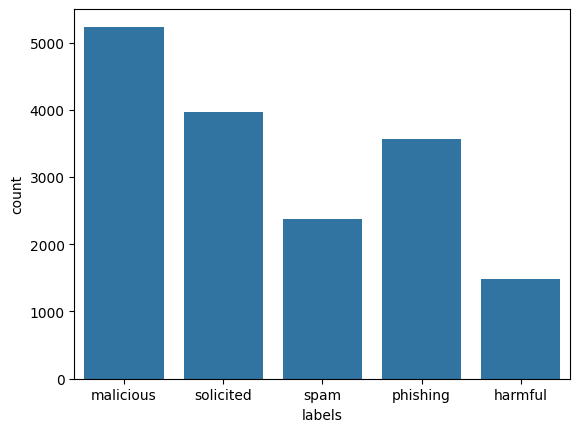

In [123]:
sns.countplot(x='labels', data=df)
plt.show()


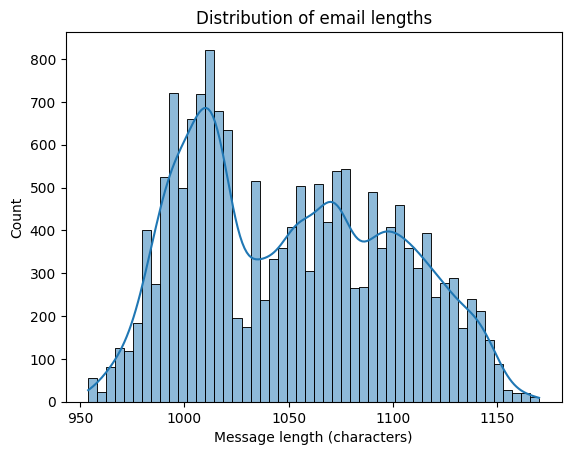

In [124]:
# df['length'] = df['message'].apply(len)
# sns.distplot(df['length'])

df['length'] = df['message'].apply(len)

sns.histplot(df['length'], bins=50, kde=True)
plt.xlabel("Message length (characters)")
plt.ylabel("Count")
plt.title("Distribution of email lengths")
plt.show()

In [125]:
df[df['length']>20]['labels'].value_counts() #.count()

labels
malicious    5236
solicited    3966
phishing     3570
spam         2376
harmful      1484
Name: count, dtype: int64

In [127]:
for index in df[df['length']>2500].index.tolist():
    df.drop(index=index, axis=1, inplace=True)
    

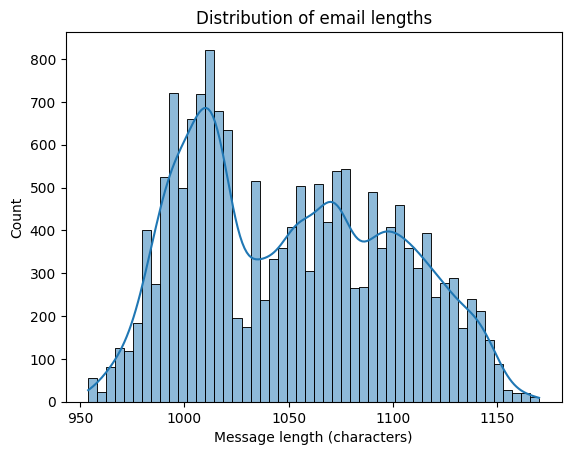

In [128]:
df['length'] = df['message'].apply(len)

sns.histplot(df['length'], bins=50, kde=True)
plt.xlabel("Message length (characters)")
plt.ylabel("Count")
plt.title("Distribution of email lengths")
plt.show()

array([[<Axes: title={'center': 'harmful'}>,
        <Axes: title={'center': 'malicious'}>],
       [<Axes: title={'center': 'phishing'}>,
        <Axes: title={'center': 'solicited'}>],
       [<Axes: title={'center': 'spam'}>, <Axes: >]], dtype=object)

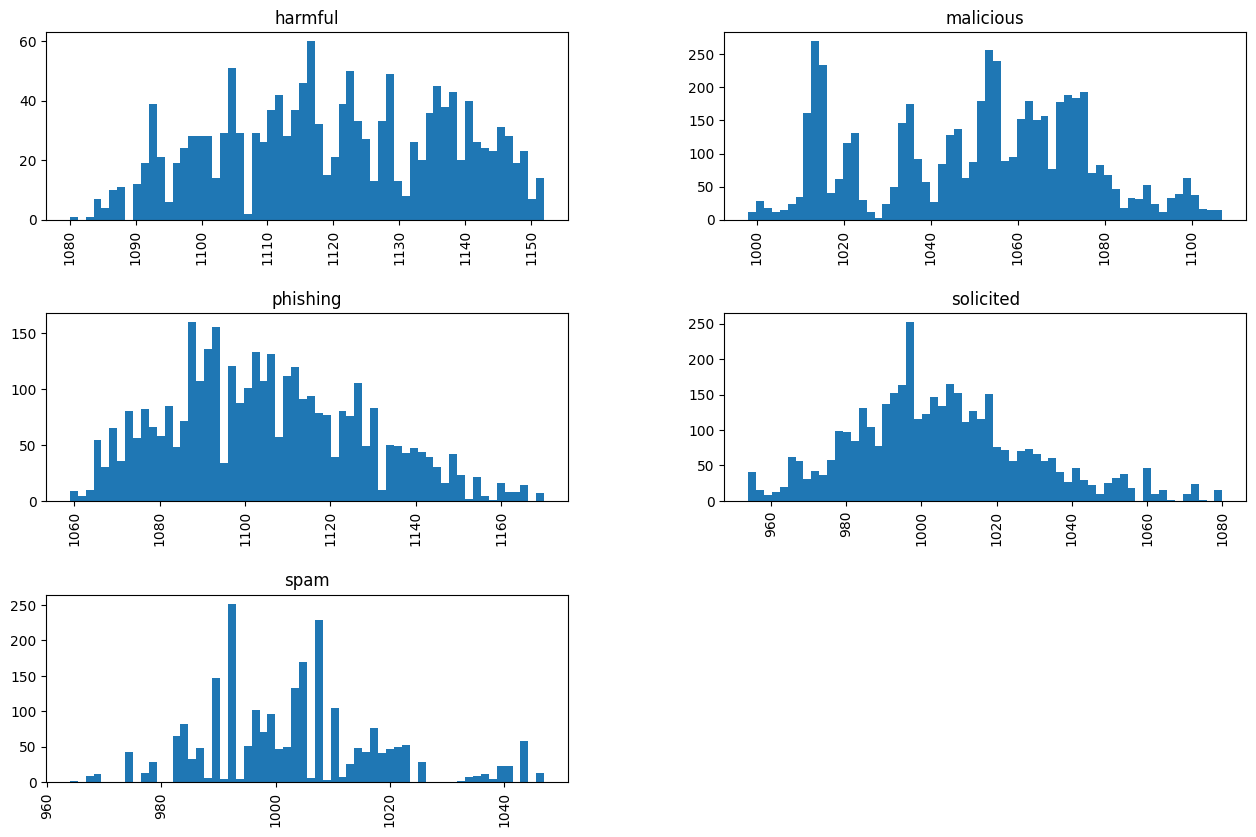

In [129]:
df.hist('length', by='labels', figsize=(15, 10), bins=60)

## Applying NLP; BOW, TF-IDF

In [130]:
import string
from nltk.corpus import stopwords
def text_process(message):
    noPunc = [char for char in message if char not in string.punctuation]
    noPunc = ''.join(noPunc)
    
    return [word for word in noPunc.split() if word not in stopwords.words('english')]

In [131]:
df['message'] = df['message'].apply(text_process)

In [132]:
df['message'] = df['message'].apply(lambda x: ' '.join(x))

In [133]:
df['message'].head()

0    software update detail bypass activation sampl...
1    service message appointment reminder sample so...
2    service message ticket ha updated sample sol 0...
3    limited promotion winner lottery sample spa 01...
4    deal notification earn money home sample spa 0...
Name: message, dtype: object

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer().fit(df['message'])

In [135]:
print(len(bow_transformer.vocabulary_))

5657


In [136]:
message_bow = bow_transformer.transform(df['message'])

In [137]:
sparsity = (100.0 * message_bow.nnz/(message_bow.shape[0] * message_bow.shape[1]))
print('sparsity {}'.format(sparsity))

sparsity 1.607128933892236


In [138]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer_bow = TfidfTransformer().fit(message_bow)

In [139]:
message_tfidf = tfidf_transformer_bow.transform(message_bow)

In [140]:
from sklearn.naive_bayes import MultinomialNB

def buildClassifier(alpha):
    text_classifier = MultinomialNB(alpha=alpha)
    return text_classifier

## Making the pipeline, making it production ready!

In [141]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('vec', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB(alpha=0.01))])


<b> Grid Search for best parameters. </b>

In [142]:
from sklearn.model_selection import GridSearchCV

In [143]:
parameters = {'clf__alpha': (0.00001, 0.0001, 0.001, 0.01, 0.1, 0.8, 0.9, 1)}
grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring='accuracy', cv=10, verbose=1)

In [144]:
grid_search.fit(df['message'], df['labels'])
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


In [147]:
best_parameters

{'clf__alpha': 1e-05}

In [157]:
best_accuracy

np.float64(1.0)

In [149]:
pipeline = Pipeline([('vec', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB(alpha=0.1))])

In [150]:
pipeline.fit(df['message'], df['labels'])

Pipeline(steps=[('vec', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.1))])

In [151]:
input_word = ['Download this app for free music']
input_word = text_process(input_word)
input_word = [' '.join(input_word)]
pipeline.predict(input_word)

array(['spam'], dtype='<U9')

# Saving the Pipeline to be integrated in our web-app

In [153]:
import pickle

In [154]:
filename = 'textClf.pkl'
pickle.dump(pipeline, open(filename, 'wb'))